## NB
The data used in this notebook was generated with individual ssGSEA runs for each gene set. It means that the enrichment scores aren't corrected within the whole dataset. Please look at "Per Patient Subtype Analysis" for the updated analysis.

In [1]:
using Pkg
using DataFrames
using CSV
using Printf
using Plots
using StatsPlots
using Statistics

In [2]:
function parseGCT(fileName)
    rowCount = 0
    version = ""
    rows = 0
    cols = 0
    rowMetadata = 0
    labels = Array{String}[]
    values = Array{}[]
    for row in eachline(fileName)
        if rowCount == 0
            version = row
        elseif rowCount == 1
            # Parse sizes
            splitRow = split(row, "\t")
            row = map(x -> parse(Int, x), splitRow)
            rows = row[1]
            cols = row[2]
            rowMetadata = row[3]
        elseif rowCount == 2
            # Parse Labels
            labels = split(row, "\t")
        elseif rowCount == 3
            # Parse Values
            values = split(row, "\t")
        end
        rowCount += 1
    end
    parsedData = collect(zip(labels, values))
    metaData = parsedData[1:3]
    overlapPercents = parsedData[4:53]
    overlapSignatures = parsedData[54:103]
    pValues = parsedData[105:154]
    fdrPValues = parsedData[155:204]
    scores = parsedData[205:254]
    annotationsFrame = CSV.read("../data/Annotation_col.csv", DataFrame)
    df = DataFrame(
        annotations = annotationsFrame[!, :Annotation],
        samples = labels[205:254], 
        scores = map(x -> parse(Float64, x), values[205:254]),
        pValues = map(x -> parse(Float64, x), values[105:154]),
        fdrPValues = map(x -> parse(Float64, x), values[155:204])
    )
    return df
end

parseGCT (generic function with 1 method)

In [3]:
classical = parseGCT("../data/classical/countMatrix_ssGSEA-combined.gct")
mesenchymal = parseGCT("../data/mesenchymal/countMatrix_ssGSEA-combined.gct")
neural = parseGCT("../data/neural/countMatrix_ssGSEA-combined.gct")
proneural = parseGCT("../data/proneural/countMatrix_ssGSEA-combined.gct")

,annotations,samples,scores,pValues,fdrPValues
,String,SubStri…,Float64,Float64,Float64
1,Core,Sample_27_1,12.1707,0.001,0.001
2,Rim,Sample_27_2,12.4103,0.001,0.001
3,Inv,Sample_27_5,11.66,0.001,0.001
4,Neg,Sample_27_neg,11.9934,0.001,0.001
5,Pos,Sample_27_pos,1.3237,0.297297,0.297297
6,Core,Sample_28_1,10.6581,0.001,0.001
7,Rim,Sample_28_2,10.4153,0.001,0.001
8,Inv,Sample_28_5,9.3141,0.001,0.001
9,Neg,Sample_28_neg,6.8834,0.001,0.001


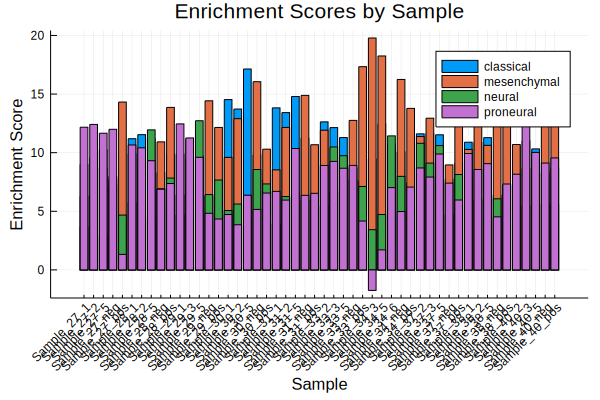

In [4]:
bar(classical.scores, 
    label = "classical", 
    xticks = (1:50, classical.samples), 
    xrotation=45,
    title = "Enrichment Scores by Sample")
xlabel!("Sample")
ylabel!("Enrichment Score")
bar!(mesenchymal.scores, label = "mesenchymal")
bar!(neural.scores, label = "neural")
bar!(proneural.scores, label = "proneural")

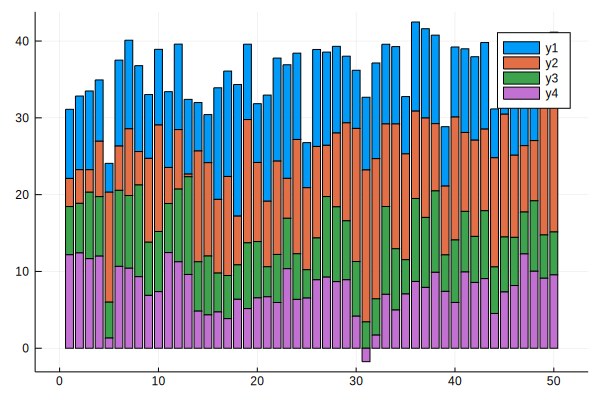

In [5]:
matrixData = [classical.scores mesenchymal.scores neural.scores proneural.scores]
groupedbar(matrixData, bar_position = :stack)

In [6]:
function groupByAnnotation(dataFrame)
    groupedClassical = groupby(dataFrame, :annotations)
    combined = combine(groupedClassical, :scores => mean)
    return combined
end

groupByAnnotation (generic function with 1 method)

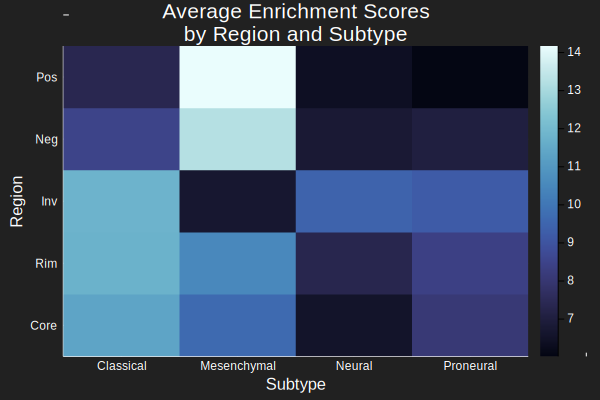

In [7]:
xlabel = ["Classical", "Mesenchymal", "Neural", "Proneural"]
classicalGrouped = groupByAnnotation(classical)
mesenchymalGrouped = groupByAnnotation(mesenchymal)
neuralGrouped = groupByAnnotation(neural)
proneuralGrouped = groupByAnnotation(proneural)
heatmapData = [classicalGrouped.scores_mean (
            mesenchymalGrouped.scores_mean) (
            neuralGrouped.scores_mean) (
            proneuralGrouped.scores_mean)]
heatmap(heatmapData,
    title = "Average Enrichment Scores \nby Region and Subtype",
    xlabel="Subtype",
    ylabel="Region",
    background_color = colorant"#212121ff",
    c = :ice,
    yticks=(1:50, classicalGrouped.annotations),
    xticks=(1:5, xlabel))
# savefig("Average Enrichment Scores by Region and Subtype Heatmap")

In [13]:
proneuralGrouped

,annotations,scores_mean
,String,Float64
1,Core,8.06519
2,Rim,8.3628
3,Inv,9.19727
4,Neg,7.01639
5,Pos,6.01968
